In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.signal as signal
import matplotlib.pyplot as plt

from tqdm import tqdm
from cmcrameri import cm
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit


from src.AnalysisFunctions import *
from src.Segmentation3D import get_voxel_size_35mm
from src.HolomonitorFunctions import get_pixel_size
from src.FormatConversions import import_holomonitor_stack, import_tomocube_stack

In [3]:
# experimental parameters
vox_to_um = get_voxel_size_35mm()
pix_to_um = get_pixel_size()

dt = 4 # h
dt_holo = 12 # frames per hour
dt_tomo = 4  # frames per hour
blur_factor = 1.5
#holomonitor_scaling = 100

fmin_holo = 1
fmax_holo = 181

fmin_tomo = 0
fmax_tomo = 40

In [4]:
frame = 30
folder = "../../data/Holomonitor/MDCK_19.03.2024/"
file = "A1-9"

# import data
h_im = import_holomonitor_stack(folder, file, f_min=frame, f_max=frame+1)
df = pd.read_csv(f"{folder}{file}/area_volume_filtered.csv")

r_cell = average_cell_radius(df, frame, pix_to_um, blur_factor=1)

# file = "250210.113448.MDCK dynamics.001.MDCK B.A2"
# folder = "../../data/Tomocube/MDCK_10.02.2025/A2P1/"

# _, h_im = import_tomocube_stack(folder, file, f_min=0, f_max=1, h_scaling=vox_to_um[0])
# df = pd.read_csv(f"{folder}/area_volume_unfiltered.csv")
# r_cell = average_cell_radius(df, frame, vox_to_um, blur_factor=1)

In [5]:
fluct_pixel = compute_flatness(h_im, df)[2][0]
fluct_cell  = compute_flatness_cellwise(df, frame-1, frame)[2][0]

In [6]:
r_arr = np.linspace(0, 4.5, 10) / 3
fluct_disk = np.zeros_like(r_arr)

i = 0
for r in r_arr:
    sigma = r*r_cell
    hblur = gaussian_filter(h_im, sigma)
    fluct_disk[i] = compute_flatness(hblur, df)[2][0]

    i += 1

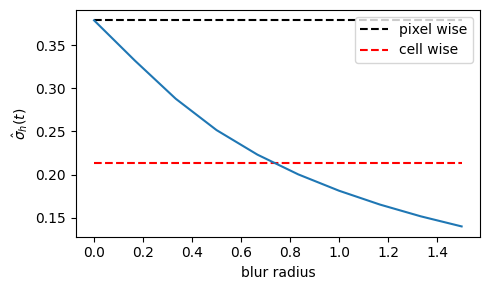

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.hlines(fluct_pixel, min(r_arr), max(r_arr), linestyles="dashed", color="k", label="pixel wise")
ax.hlines(fluct_cell,  min(r_arr), max(r_arr), linestyles="dashed", color="r", label="cell wise")
ax.plot(r_arr, fluct_disk)

ax.set(ylabel=r"$\hat{\sigma}_h(t)$", xlabel=r"blur radius")
ax.legend()
fig.tight_layout()

In [8]:
fig.savefig(f"../../figs/blurring/gaussian_sigma_holomonitor_frame_{frame}.png")